### Cluster definition and visualization

Clustering is an unsupervised machine learning techniques consisting in grouping unlabeled examples. The goal of this process is creating a data-drive classification of the observation and to infere relevant common feature. The implemented algorithm (see reference Python file [here](../clusteralgo.py); the code is based on this [article](https://medium.com/@sk.shravan00/k-means-for-3-variables-260d20849730)) starts from the four mashed up datasets, referred to the four considered academic years. The first step is to create a syntetic visualization of the available data as the diachronical development over time is not considerably relevant. <br>
The reference dataframe will show the average value among the reference years (a.y. 2015/2016 - 2018/19) for the observations presented in all the four datasets (which coincide with the observation taken in 2016, which is the file containing fewer data). To this end, two ancillaries function are developed:
- <code>listOfVal</code> gets all the values of a specific variables over time, storing it into a list
- <code>averageVal</code> relies on the previous function to add a new column to a dataframe, containing the averaged value of the given variable

In [1]:
import pandas as pd
import statistics

def listOfVal(series, parameter):
    outputList = [
        series["{0}_2016".format(parameter)],
        series["{0}_2017".format(parameter)],
        series["{0}_2018".format(parameter)],
        series["{0}_2019".format(parameter)],
    ]
    return outputList

def averageVal(df, parameter):
    outputList = []
    for idx, row in df.iterrows():
        val = statistics.fmean(listOfVal(row, parameter))
        outputList.append(val)
    df[parameter] = outputList
    return df

We can hence obtain the desired dataset, which will be saved separatedly into a CSV file. This operation will streamline the creation of heatmaps, as described in the [corresponding notebook](geomap.ipynb).

In [4]:
# Create a single dataset with average values

df1 = pd.read_csv("../../data/output/2016.csv")
df2 = pd.read_csv("../../data/output/2016.csv")
df3 = pd.read_csv("../../data/output/2016.csv")
df4 = pd.read_csv("../../data/output/2016.csv")

df1 = df1.merge(df2, left_on='uni_id', right_on='uni_id', suffixes=('_2016', '_2017'))
df1 = df1.merge(df3, left_on='uni_id', right_on='uni_id', suffixes=('_2017', '_2018'))
df1 = df1.merge(df4, left_on='uni_id', right_on='uni_id', suffixes=('_2018', '_2019'))

df1 = averageVal(averageVal(averageVal(df1, "perc_intern"), "relative_scholarship"), "paidfee")

data = df1[["uni_2016", "relative_scholarship", "perc_intern", "paidfee"]].rename(columns={"uni_2016": "uni"})
data.to_csv("../../data/output/averages.csv", index=False)

The first step of the algorithm is aimed at determining the number of centroids. The library [scikit-learn](https://scikit-learn.org/stable/) allows to implement the "elbow method" to perform this computation. Visaulizations are obtained through [matplotlib](https://matplotlib.org/). See the referenced article for a more torough description of the code

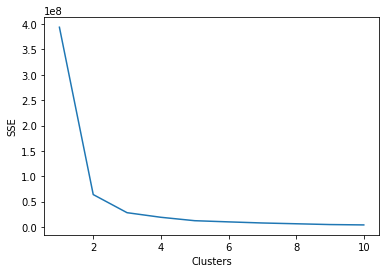

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import cluster

X = data.iloc[:,1:4].values

# Apply elbow method to understand the number of cluster

wcss = []
for i in range(1,11):
    k_means = cluster.KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    wcss.append(k_means.inertia_) 

plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

The previous step proves that we have to consider 3 centroids. The model is tuned and the dataframe is updated: each university is now associated to the belonging cluster (labelled as 0, 1, 2). 

In [6]:
# Update the dataframe with the association university - cluster 

k_means_optimum = cluster.KMeans(n_clusters = 3, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X)

data['cluster'] = y 

The three variables (international students rate, fees, scholarship) are then isolated and the distance from the centroids are calculated. These informations are then visualized in a 3D space: each variable is hence represented by an axis.

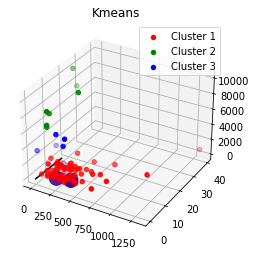

In [7]:
data1 = data[data.cluster==0]
data2 = data[data.cluster==1]
data3 = data[data.cluster==2]

kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
kplot.plot3D(xline, yline, zline, 'black')# Data for three-dimensional scattered points
kplot.scatter3D(data1.relative_scholarship, data1.perc_intern, data1.paidfee, c='red', label = 'Cluster 1')
kplot.scatter3D(data2.relative_scholarship, data2.perc_intern, data2.paidfee,c ='green', label = 'Cluster 2')
kplot.scatter3D(data3.relative_scholarship, data3.perc_intern, data3.paidfee, c='blue', label = 'Cluster 3')
plt.scatter(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], color = 'indigo', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()

This visualization is useful as shows how the observations are condensed around the lowest values of the three axes (which, again, proves wrong the research question). The difficulty of displaying almost eighty labels in such a compressed space suggests to opt for a different visualization on the main webpage. <br>
Even though they might appear more naïf, tables allow to catch rapidy the composition of the clusters. To inspect each group, the function <code>getMemberCluster</code> is implemented. Starting from the source dataframe of each cluster, it returns the universities belonging to it. An option boolean input value is responsible for the output format: either a list or an already marked-up body of HTML table (as string).

In [10]:
def getMemberCluster(df, html=None):
    outputList = []
    for idx, row in df.iterrows():
        if html:
            uni = str("<li>" + str(row["uni"]) + "</li>")
            outputList.append(uni)
        else:
            outputList.append(row["uni"])
    if html:
        outputStr = ""
        for el in outputList:
            outputStr = str(outputStr + el + "\n")
        return outputStr
    else:
        return outputList

print(getMemberCluster(data1))

['Torino', 'Torino Politecnico', 'Piemonte Orientale', 'Aosta', 'Genova', 'Insubria', 'Milano', 'Milano Politecnico', 'Milano Bicocca', 'Bergamo', 'Brescia', 'Pavia', 'Bolzano', 'Trento', 'Verona', 'Venezia C Foscari', 'Venezia Iuav', 'Padova', 'Udine', 'Trieste', 'Parma', 'Modena e Reggio Emilia', 'Bologna', 'Ferrara', 'Urbino', 'Marche', 'Macerata', 'Camerino', 'Firenze', 'Pisa', 'Siena', 'Siena Stranieri', 'Perugia', 'Perugia Stranieri', 'Tuscia', 'Roma La Sapienza', 'Roma Tor Vergata', 'Roma Foro Italico', 'Roma Tre', 'Cassino', 'Sannio', 'Napoli Federico II', 'Napoli Parthenope', "Napoli L'Orientale", 'Napoli Benincasa', 'Napoli Vanvitelli', 'Salerno', "L'Aquila", 'Teramo', 'Chieti e Pescara', 'Molise', 'Foggia', 'Bari', 'Bari Politecnico', 'Salento', 'Basilicata', 'Calabria', 'Catanzaro', 'Reggio Calabria', 'Reggio Calabria - Dante Alighieri', 'Palermo', 'Messina', 'Enna KORE', 'Catania', 'Sassari', 'Cagliari']
